In [3]:
format compact
% You may need to insert an addpath statement here to .../Dropbox/.../BenA/Jupyter for full functionality. I'm 
% not sure how this runs on other devices or what files it will be able to access but everything you need
% should be in that folder.

%some utility things for plots
color0 = [0, 0.4470, 0.7410];
color1 = [0.8500, 0.3250, 0.0980];
color2 = [0.9290, 0.6940, 0.1250];
color3 = [0.4940, 0.1840, 0.5560];
color4 = [0.4660, 0.6740, 0.1880];
colorf = 'black';

addpath './code'

# Magnus Expansion Tools - Project Log
## Ben Alford  -  Dartmouth College  -  March 2021

The objective of this project was to write code to calculate the size of the first few terms of the Magnus expansion for different pulse sequences and different values of the system parameters.   This tool can be used to determine the magnus expansion terms for any arbitrary pulse sequence, though the computation time grows rapidly for longer sequences.  The parameters considered were the delay spacing in between pulses (tau), the strength of the dipole hamiltonian (coupling) and the strength of the offset hamiltonian (Delta) which combines the resonance offset and chemical shift of the system.

The formula currently in use for the size $h_n$ of a term $H^{(n)}$ in the expansion is: $$h_n=\sqrt{\text{Tr}\left(H^{(n)}.H^{(n)}\right)}$$ 

This formula was later updated to the following (the earlier plots use the above metric; the point where the metric changes to the metric below is indicated in the notebook):
$$\text{Size}\big(\bar H^{(n)}\big)=\sqrt{\frac{\text{Tr}\big(\bar H^{(n)}.\bar H^{(n)}\big)}{\text{Tr}\big(H_{sys}.H_{sys}\big)}}$$

Existing code from the Spin Simulation script is used construct the spin operators and set the initial parameters.

In [2]:

N = 4;
dim = 2^N;
Ncyc = 1;
pulse = 0;
tau = 3e-6;  % delay spacing
coupling = 5000;
f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
w1 = 2*pi*f1;
Delta = 500;

% initvars
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


%initCollectiveObs;
Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);
for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end


'mykron' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


I likewise used existing code to generate the dipole hamiltonian.  I generated a set of 8 to use (changeable using the variable **couplingsCount**) based on random coupling matrices.

In [3]:
couplingsCount = 8;
Hdips = cell(couplingsCount,1);
% Generate 8 dipole Hamiltonians, each with a different coupling matrix
for j=1:couplingsCount
    dip = abs(randn(N));
    dip = triu(dip,1) + triu(dip,1)';
    Hdips{j} = getHdip(N, dim, x, y, z, dip);
end

'getHdip' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


A pulse sequence must then be chosen.  If the sequence is already in the script, then its name can be entered into the variable **sequenceName**. A set of if/else statements using **strcmp** will later select the proper set of pulses and delays.

In [115]:
sequenceName = 'WHH';

Pulse sequences are entered into the script as a pair of arrays.  The first array, **Pulses**, is a Cell array consisting of the pulse sequence.  The second array, **Taus**, is a regular list array consisting of the spacing that precedes each pulse in the Cell array.  The length of the second array should always be one entry longer than the first array.

In [5]:
%WAHUHA
if strcmp(sequenceName, 'WHH')
    Pulses = {-X, Y, -Y, X};
    Taus = [tau tau 2*tau tau tau];
    
%MREV-8
elseif strcmp(sequenceName, 'MREV8')
    Pulses = {-X, -Y, Y, X, X, -Y, Y, -X}; % Check this
    Taus = [tau tau 2*tau tau 2*tau tau 2*tau tau tau];

%CORY 48
elseif strcmp(sequenceName, 'CORY48')
    Pulses = {X, Y, -X, Y, X, Y, X, Y, X, -Y, X, Y, -Y, -X, Y, -X, -Y, -X, -Y, -X, -Y, X, -Y, -X, -X, Y, -X, -Y, -X, Y, X, -Y, -X, -Y, X, -Y, Y, -X, Y, X, Y, -X, -Y, X, Y, X, -Y, X};
    Taus = [tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau 2*tau tau tau];
end
    
tCyc = sum(Taus);

## Change of Frame Function

The system being considered evolves under the hamiltonian:  $$H(t)=H_{\text{rf}}+H_\text{dip}+H_{\text{CS}}+H_{\Delta \omega}$$
Of the four terms above, only $H_{\text{rf}}$ is time-dependent.  Therefore, we use a change of frame to eliminate $H_{\text{rf}}$ and let $$H_{\text{sys}}=H_\text{dip}+H_{\text{CS}}+H_{\Delta \omega}$$

Since $H_{\text{CS}}$ and $H_{\Delta \omega}$ are both proportional to $I_z$, we combine these terms and let the parameter $\Delta$ describe their magnitude.  This leaves us with $$H_{\text{sys}}=H_\text{dip}+\Delta I_z$$

which is time-independent.

We can then write our toggled Hamiltonian $\tilde H(t)$ as follows.  $$\tilde H(t)=U_\text{rf}^\dagger(t) H_\text{sys} U_\text{rf}(t)$$

where $$U_\text{rf}(t)=\mathcal{T}e^{\int_0^t \text{d}t' H_\text{rf}(t')}$$


The code below is used to calculate $U_\text{rf}$ after the first *frame* pulses of a sequence. (Again, this code will not run in Jupyter but the function has been imported and can be used later in the notebook)  

In [6]:
function URF = getURF(frame)
    global dim Pulses
    
    if frame < 1
        URF = speye(dim,dim); %After zero pulses, the frame unitary is just the identity

    else
        URF = expm(-1i*Pulses{1}*pi/2);
    end
    
    if frame > 1
        for j=2:frame
            URF = expm(-1i*Pulses{j}*pi/2) * URF; % it is important that this multiplication happens on the left
        end
    end
end

Error: Function definition not supported in this context. Create functions in code file.


Since $H(t)$ is piecewise time-independent, we calculate the frame-toggling unitary after $k$ pulses have been applied to the system to be $$U_{rf}(k)=\prod_{j=1}^k e^{\frac{-i\pi}{2}P_j}$$ where $P_j$ is the spin operator (one of $X,Y,\bar X,\bar Y$) corresponding to the $j$th pulse.  Note that if $k=0$ then $U_{rf}=\mathbb{1}$.

The product is time-ordered such that: $$U_{rf}(k)=e^{\frac{-i\pi}{2}P_k}\cdot\cdot\cdot e^{\frac{-i\pi}{2}P_1}$$

We then write the toggled-frame Hamiltonian after $k$ pulses have been applied as: $$\tilde H_{sys}(k)=U^\dagger_{rf}(k)H_{sys}(k)U_{rf}(k)$$

## Calculating Magnus Terms

The code below is used to calculate the 0th to 4th order terms of the Magnus Expansion and their orders, in combination with the getURF function and the input parameters above.  Note that the code below will not run.  In all cases the variable *Hn* represents the nth term of the magnus expansion and *hn* is the order of that matrix.

In [7]:
H0 = zeros(dim,dim);
for k=0:length(Pulses)
    URF = getURF(k);
    Htilde = (URF')*Hsys*URF;
    Taus(k+1);
    H0 = H0 + (Taus(k+1))*Htilde;
end

H0 = (1/tCyc)*H0;
h0 = real(matOrder(H0));

'getURF' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


Since $H$ is piecewise time-independent, the zeroth order term is evaluated as $$\bar H^{(0)}=\frac{1}{t_{cyc}}\sum_{k=0}^{n_p}U^\dagger_{rf}(k)H_{sys}(k)U_{rf}(k)\tau_k=\frac{1}{t_{cyc}}\sum_{k=0}^{n_p}\tilde H_{sys}(k)\tau_k$$ where $n_p$ is the number of pulses in the sequence, $t_{cyc}$ is the cycle time, $U_{rf}(k)$ is the frame-toggling unitary given above, and $\tilde H_{sys}$ is the toggled Hamiltonian as defined above.

In [8]:
H1 = zeros(dim,dim);
for k=1:length(Pulses)
    for j=0:k-1
        Hk = getURF(k)'*Hsys*getURF(k);
        Hj = getURF(j)'*Hsys*getURF(j);
        H1 = H1 + comm(Hk,Hj)*Taus(k+1)*Taus(j+1);
    end
end

H1 = (1/(2*1i*tCyc))*H1;
h1 = real(matOrder(H1));

'getURF' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


The first-order term is given by: $$\bar H^{(1)}=\frac{1}{2it_{cyc}}\sum_{k=0}^{n_p}\sum_{j=0}^{k-1}\left[H(k),H(j)\right]\tau_j\tau_k$$

In [9]:
H2 = zeros(dim,dim);
for l=0:length(Pulses)
    for k=0:l
        for j=0:k
            Hl = getURF(l)'*Hsys*getURF(l);
            Hk = getURF(k)'*Hsys*getURF(k);
            Hj = getURF(j)'*Hsys*getURF(j);

            Hterm = comm(Hl,comm(Hk,Hj))+comm(comm(Hl,Hk),Hj);
            H2 = H2 + Hterm*Taus(l+1)*Taus(k+1)*Taus(j+1);
        end
    end
end

H2 = (-1/(6*tCyc))*H2;
h2 = real(matOrder(H2));

'getURF' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


The second-order term is given by: $$\bar H^{(2)}=\frac{-1}{6t_{cyc}}\sum_{\ell=0}^{n_p}\sum_{k=0}^{\ell}\sum_{j=0}^k \left([H(\ell),[H(k),H(j)]]+[[H(\ell),H_k],H_j]\right)\tau_\ell\tau_k\tau_j$$

The code used to generate higher order terms is shown below; their formulas are not written out explicitly.

In [10]:
H3 = zeros(dim,dim);
for m=0:length(Pulses)
    for l=0:m
        for k=0:l
            for j=0:k
                Hm = getURF(m)'*Hsys*getURF(m);
                Hl = getURF(l)'*Hsys*getURF(l);
                Hk = getURF(k)'*Hsys*getURF(k);
                Hj = getURF(j)'*Hsys*getURF(j);

                term1 = comm(comm(comm(Hm,Hl),Hk),Hj);
                term2 = comm(Hm,comm(comm(Hl,Hk),Hj));
                term3 = comm(Hm,comm(Hl,comm(Hk,Hj)));
                term4 = comm(Hl,comm(Hk,comm(Hj,Hm)));

                Hterm = term1+term2+term3+term4;
                tauProd = Taus(m+1)*Taus(l+1)*Taus(k+1)*Taus(j+1);

                H3 = H3 + Hterm*tauProd;
            end
        end
    end
end

H3 = (-1/(12*1i*tCyc))*H3;
h3 = real(matOrder(H3));

'getURF' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


In [11]:
H4 = zeros(dim,dim);
for mm=0:length(Pulses)
    for m=0:mm
        for l=0:m
            for k=0:l
                for j=0:k
                    % Express Hsys(t) in the interaction frame
                    Hmm = getURF(mm)'*Hsys*getURF(mm);
                    Hm = getURF(m)'*Hsys*getURF(m);
                    Hl = getURF(l)'*Hsys*getURF(l);
                    Hk = getURF(k)'*Hsys*getURF(k);
                    Hj = getURF(j)'*Hsys*getURF(j);

                    % Calculate commutators
                    term1 = (-1/30)*comm(Hmm,comm(Hmm,comm(Hl,comm(Hk,Hj))));
                    term2 = (2/15)*comm(Hj,comm(Hmm,comm(Hm,comm(Hk,Hl))));
                    term3 = (1/15)*comm(comm(Hmm,Hj),comm(Hm,comm(Hk,Hl)));
                    term4 = (1/15)*comm(comm(Hm,Hj),comm(Hmm,comm(Hk,Hl)));
                    term5 = (-1/60)*comm(comm(Hk,Hl),comm(Hmm,comm(Hm,Hj)));
                    term6 = (1/15)*comm(comm(Hl,Hj),comm(Hmm,comm(Hk,Hm)));
                    term7 = (-1/60)*comm(comm(Hk,Hm),comm(Hmm,comm(Hl,Hj)));
                    term8 = (-1/60)*comm(comm(Hk,Hmm),comm(Hm,comm(Hl,Hj)));
                    term9 = (-1/60)*comm(comm(Hl,Hm),comm(Hmm,comm(Hk,Hj)));
                    term10 = (-1/60)*comm(comm(Hl,Hm),comm(Hj,comm(Hk,Hmm)));
                    term11 = (-1/60)*comm(comm(Hmm,Hj),comm(Hl,comm(Hk,Hm)));
                    term12 = (-1/60)*comm(comm(Hm,Hj),comm(Hl,comm(Hk,Hmm)));
                    term13 = (-1/60)*comm(comm(Hl,Hmm),comm(Hm,comm(Hk,Hj)));
                    term14 = (-1/60)*comm(comm(Hl,Hmm),comm(Hj,comm(Hk,Hm)));
                    term15 = (-1/30)*comm(Hj,comm(Hm,comm(Hl,comm(Hk,Hmm))));
                    term16 = (-1/60)*comm(comm(Hm,Hmm),comm(Hj,comm(Hk,Hl)));
                    term17 = (-1/60)*comm(comm(Hk,Hl),comm(Hj,comm(Hm,Hmm)));
                    term18 = (-1/60)*comm(comm(Hk,Hm),comm(Hj,comm(Hl,Hmm)));
                    term19 = (-1/60)*comm(comm(Hk,Hj),comm(Hm,comm(Hl,Hmm)));
                    term20 = (-1/60)*comm(comm(Hm,Hmm),comm(Hl,comm(Hk,Hj)));
                    term21 = (-1/60)*comm(comm(Hl,Hj),comm(Hm,comm(Hk,Hmm)));
                    term22 = (-1/30)*comm(Hj,comm(Hmm,comm(Hl,comm(Hk,Hm))));

                    % Add commutators
                    Hterm = term1+term2+term3+term4+term5+term6+term7+term8+term9+term10+term11+term12+term13+term14+term15+term16+term17+term18+term19+term20+term21+term22;
                    tauProd = Taus(mm+1)*Taus(m+1)*Taus(l+1)*Taus(k+1)*Taus(j+1);

                    H4 = H4 + Hterm*tauProd;
                end
            end
        end
    end
end

H4 = (1/tCyc)*H4;
h4 = real(matOrder(H4));


'getURF' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/alfordb/Documents/MATLAB/code

Change the MATLAB current folder or add its folder to the MATLAB path.


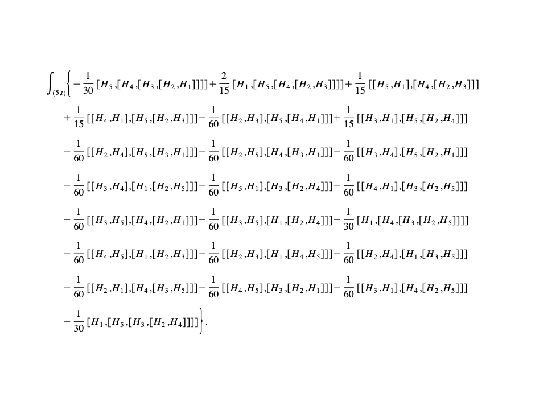

In [12]:
%plot inline
img=imread('Magnus(4).png');
imshow(img)

## Results

The default values for parameters when they were not being tested were:

$\Delta=500\text{ Hz}$

$\tau=3\text{ }\mu\text{s}$

$\text{Coupling}=5000\text{ Hz}$

## Initial Tests

These are the results of tests run on December 7-10, 2020.  Three single-parameter tests were run; one each for Delta, Tau and coupling.

For the Delta experiment, the following setup parameters were used.  100 different values of Delta, spaced at 50Hz intervals from 50 Hz to 5000 Hz, were used.

In [13]:
sequenceName = 'WHH';  % select sequence to test over
testVarName = 'Delta'; % only affects file name currently
testValueCount = 100;
testValueMax = 5000;

The results of this test are shown below.  Since WHH-4 is a symmetric pulse sequence, all odd-numbered terms of the Magnus Expansion are equal to zero.  These terms were calculated and the test followed this prediction with the values of **h1** and **h3** less than -17.  

Plots of the values of **h2** and **h4** as functions of **Delta** are shown below, along with **h0** for scale.

In [14]:
% Configure Plots
deltas = load('results/12-7-20/Deltas_WHH_Delta_magnus_results_07-Dec-2020.mat').testVars;
results_h0 = load('results/12-7-20/h0_WHH_Delta_magnus_results_07-Dec-2020.mat').results_h0;
results_h2 = load('results/12-7-20/h2_WHH_Delta_magnus_results_07-Dec-2020.mat').results_h2;
results_h4 = load('results/12-7-20/h4_WHH_Delta_magnus_results_07-Dec-2020.mat').results_h4;

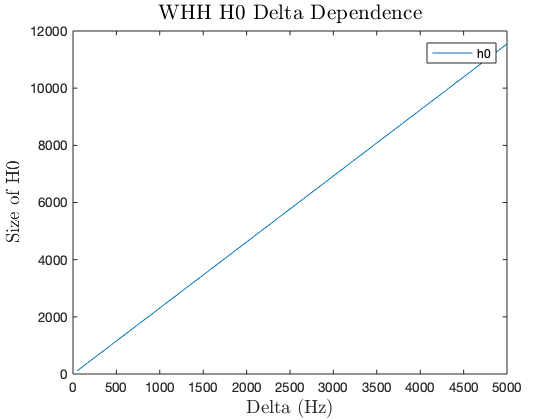

In [15]:
plot(deltas,10.^results_h0(:,1)) 
h=title('WHH H0 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H0');
set(h,'interpreter','latex','fontsize',14);
legend('h0')

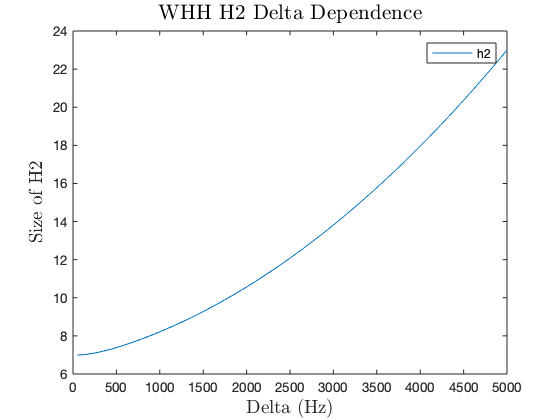

In [16]:
plot(deltas,10.^results_h2(:,1)) 
h=title('WHH H2 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);
legend('h2')

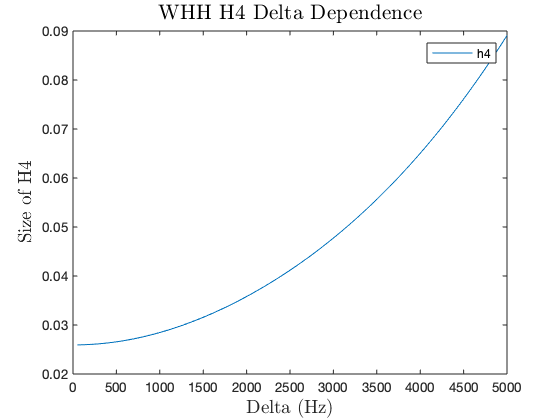

In [17]:
plot(deltas,10.^results_h4(:,1))
h=title('WHH H4 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H4');
set(h,'interpreter','latex','fontsize',14);
legend('h4')

We note the similarity in the shapes of these two plots, but the difference in the y-axes with **h4** being roughly two orders of magnitude smaller than **h2**.  We also note that the sizes of **h2,h4** approach a value greater than zero, as we would expect, since $H_{sys}$ depends on both $\Delta$ and the coupling strength.  Finally, we note these terms are several orders of magnitude smaller than **h0**.

For the Tau experiment, 60 values of Tau between 0 and 20 microseconds were used.  Once again, only **h2** and **h4** are shown below, along with **h0** for scale.  Fidelity after 20 cycles is superimposed.

In [18]:
sequenceName = 'WHH';  % select sequence to test over
testVarName = 'Tau'; % only affects file name currently
testValueCount = 60;
testValueMax = 20e-6;

In [19]:
% Configure Plots
tau_results = load('results/01-18-21/TauWHH_Tau_magnus_results_18-Jan-2021.mat');
taus = tau_results.testVars;
results_h0 = tau_results.results_h0;
results_h2 = tau_results.results_h2;
results_h4 = tau_results.results_h4;

wtaufid = load('results/04-03-21/WHH_fidelity_tau.mat');
wftaus = wtaufid.taus(:,1);
wffids = wtaufid.results(:,1);

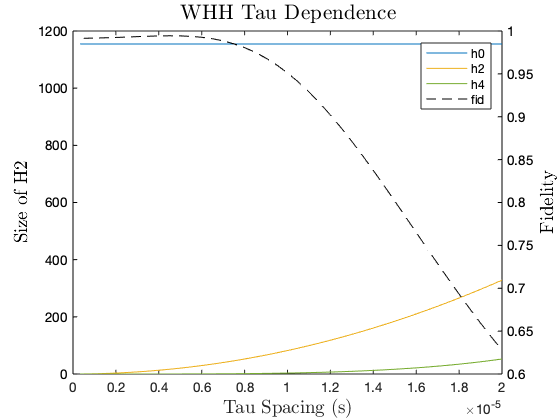

In [20]:
plot(taus,10.^results_h0(:,1))
hold on
plot(taus,10.^results_h2(:,1),'Color',color2)
plot(taus,10.^results_h4(:,1),'Color',color4)
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wftaus,wffids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h2','h4','fid')

And with **h0** removed, to make **h2**, **h4** easier to observe:

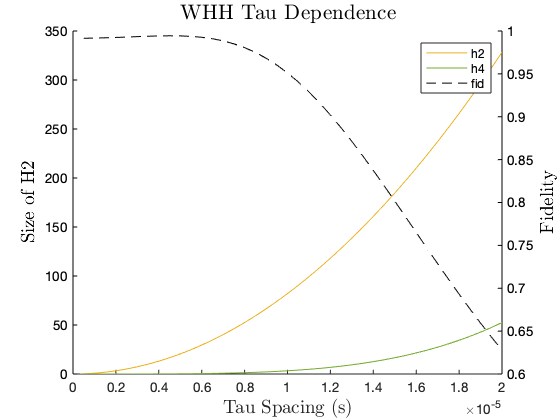

In [21]:
hold on
plot(taus,10.^results_h2(:,1),'Color',color2)
plot(taus,10.^results_h4(:,1),'Color',color4)
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wftaus,wffids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h2','h4','fid')

We note that for longer tau, the lower order terms are smaller but of the same order as **h0**.

For the coupling experiment, 100 coupling strengths were tested up to a maximum coupling strength of 50 kHz. Plots of the fidelity after 20 cycles are overlaid for comparison.

In [22]:
% Configure Plots
couplings = load('results/12-10-20/couplings_WHH_coupling_magnus_results_10-Dec-2020.mat').testVars;
results_h0 = load('results/12-10-20/h0_WHH_coupling_magnus_results_10-Dec-2020.mat').results_h0;
results_h2 = load('results/12-10-20/h2_WHH_coupling_magnus_results_10-Dec-2020.mat').results_h2;
results_h4 = load('results/12-10-20/h4_WHH_coupling_magnus_results_10-Dec-2020.mat').results_h4;

wf_couplings = load('results/04-03-21/WHH_fidelity_coupling.mat').couplings;
wf_fidelities = load('results/04-03-21/WHH_fidelity_coupling.mat').results;

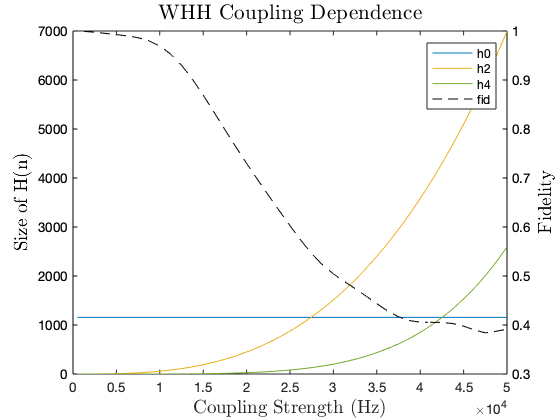

In [23]:
plot(couplings,10.^results_h0(:,1))
hold on
plot(couplings,10.^results_h2(:,1),'Color',color2)
plot(couplings,10.^results_h4(:,1),'Color',color4)
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wf_couplings(:,1),wf_fidelities(:,1),'Color',colorf,'LineStyle','--')
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor',colorf)


h=title('WHH Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
legend('h0','h2','h4','fid')

Looking more closely at the low-coupling regime:

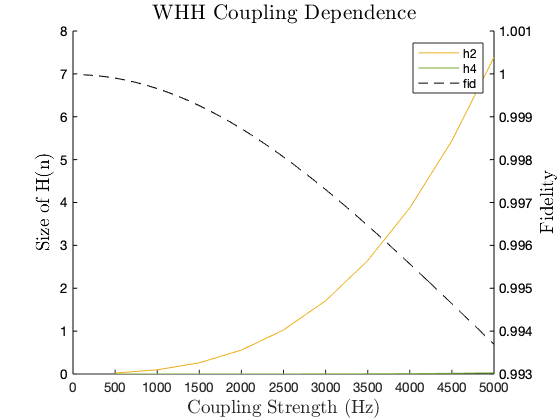

In [24]:
wfl_couplings = load('results/04-03-21/WHH_fidelity_coupling_lo.mat').couplings;
wfl_fidelities = load('results/04-03-21/WHH_fidelity_coupling_lo.mat').results;

hold on
plot(couplings(1:10),10.^results_h2(1:10,1),'Color',color2)
plot(couplings(1:10),10.^results_h4(1:10,1),'Color',color4)
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wfl_couplings(:,1),wfl_fidelities(:,1),'Color',colorf,'LineStyle','--')
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor',colorf)


h=title('WHH Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h4','fid')

Note that these terms grow dramatically as the coupling strength is increased and scale far beyond **h0** (which does not scale with coupling strength).  As such, clearly $\bar H^{(0)}$ is only a good approximation for WHH-4 for coupling strengths on the order of single kHz.

This is interesting because the fidelity for WHH fell off much more quickly as coupling strength was increased than these plots would suggest.

### MREV-8

Unlike Wahuha, MREV-8 is not a symmetric pulse sequence, so all of the terms $\bar H^{(1)}$ through $\bar H^{(4)}$ are interesting to consider.  Plots of these terms follow, over the same parameter space as those above.

In [25]:
% Configure Plots
deltas = load('results/12-10-20/Deltas_MREV8_Delta_magnus_results_10-Dec-2020.mat').testVars;
results_h0 = 10.^load('results/12-10-20/h0_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h0;
results_h1 = 10.^load('results/12-10-20/h1_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h1;
results_h2 = 10.^load('results/12-10-20/h2_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h2;
results_h3 = 10.^load('results/12-10-20/h3_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h3;
results_h4 = 10.^load('results/12-10-20/h4_MREV8_Delta_magnus_results_10-Dec-2020.mat').results_h4;

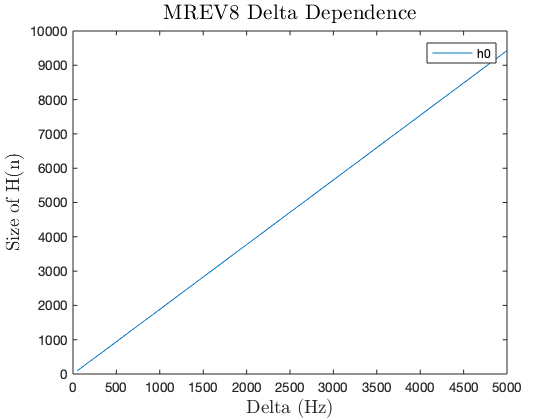

In [26]:
plot(deltas,results_h0(:,1))
h=title('MREV8 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h0')

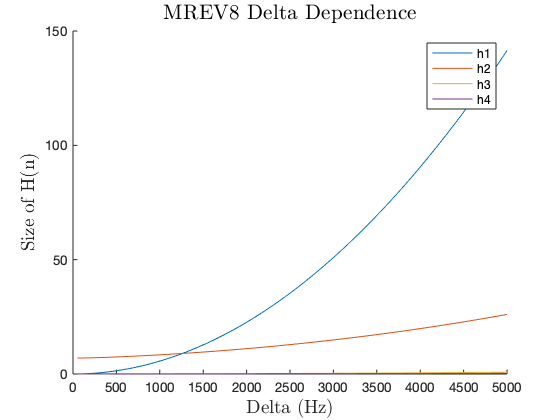

In [27]:
hold on
plot(deltas,results_h1(:,1))
plot(deltas,results_h2(:,1))
plot(deltas,results_h3(:,1))
plot(deltas,results_h4(:,1))
h=title('MREV8 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h1', 'h2', 'h3', 'h4')

A closer look at **h3** and **h4** (note the much smaller y-axis):

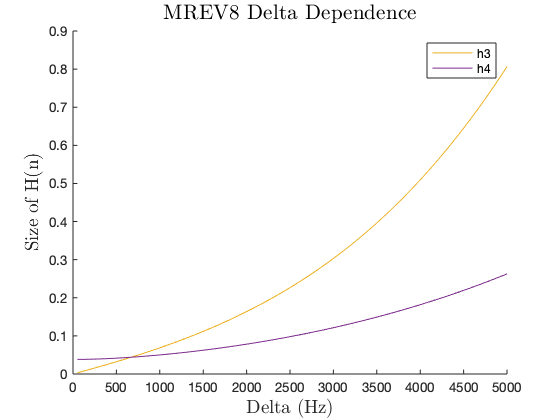

In [28]:
hold on
plot(deltas,results_h3(:,1),'Color',[0.9290, 0.6940, 0.1250])
plot(deltas,results_h4(:,1),'Color',[0.4940, 0.1840, 0.5560])
h=title('MREV8 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h3', 'h4')

Plots of the MREV-8 terms and coupling strengths follow.  We note that MREV-8 averages out the dipolar coupling to first order so the size of $\bar H^{(1)}$ does not depend on the coupling strength.

In [29]:
% Configure Plots
couplings = load('results/12-11-20/Couplings_MREV8_Coupling_magnus_results_11-Dec-2020.mat').testVars;
results_h0 = 10.^load('results/12-11-20/h0_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h0;
results_h1 = 10.^load('results/12-11-20/h1_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h1;
results_h2 = 10.^load('results/12-11-20/h2_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h2;
results_h3 = 10.^load('results/12-11-20/h3_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h3;
results_h4 = 10.^load('results/12-11-20/h4_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h4;

mf_couplings = load('results/04-03-21/MREV8_fidelity_coupling.mat').couplings;
mf_fidelities = load('results/04-03-21/MREV8_fidelity_coupling.mat').results;

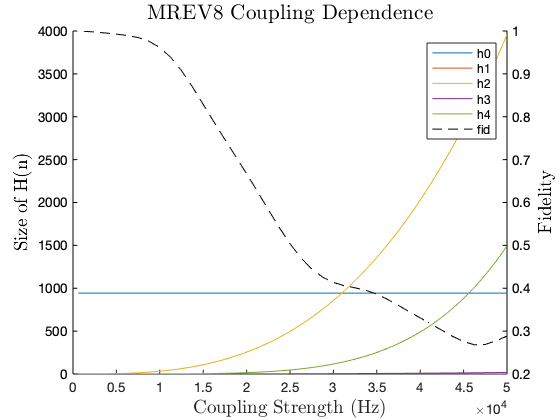

In [30]:
hold on
plot(couplings,results_h0(:,1))
plot(couplings,results_h1(:,1))
plot(couplings,results_h2(:,1))
plot(couplings,results_h3(:,1))
plot(couplings,results_h4(:,1))
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(mf_couplings(:,1),mf_fidelities(:,1),'Color',colorf,'LineStyle','--')
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor','black')

h=title('MREV8 Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
legend('h0','h1', 'h2', 'h3', 'h4','fid')

Interestingly, the even-numbered terms blow up as the coupling strength increases but the odd-numbered terms do not. Note that this is for the case $\Delta=500$ so we expect $h1<h2$ 

Here's a closer look at the odd numbered terms:

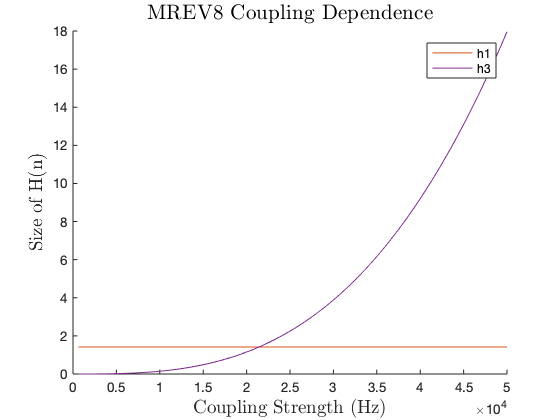

In [31]:
hold on
plot(couplings,results_h1(:,1),'Color',[0.8500, 0.3250, 0.0980])
plot(couplings,results_h3(:,1),'Color',[0.4940, 0.1840, 0.5560])
h=title('MREV8 Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
legend('h1','h3')

## Error Correlation

This code was then run for 30 values of both Delta and coupling to correspond with the grid over which earlier spin simulations of WHH-4 and MREV-8 were run.  The magnitude of h(n) for each delta-coupling pair was then plotted against the fidelity at that same delta-coupling pair for fixed values of pulse and tau.

My hope was to observe some negative correlation between fidelity (representing the error of the system) and the size of terms of the average Hamiltonian (a potential source of error).

### WAHUHA

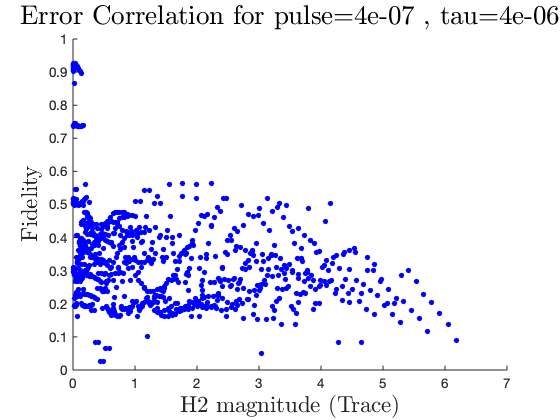

In [32]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')

h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);

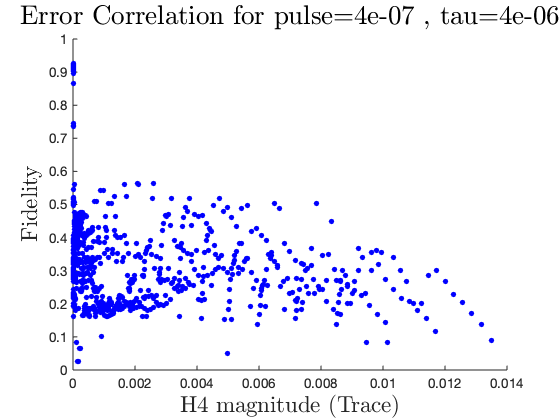

In [33]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h4_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

For the above plots, note that the shapes are very similar but the x-axes differ as H4 is much smaller than H2.

For different values of pulse and tau, the plot continues to have a strange shape.

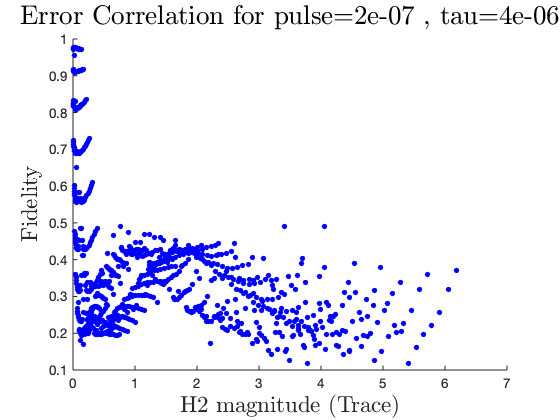

In [34]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

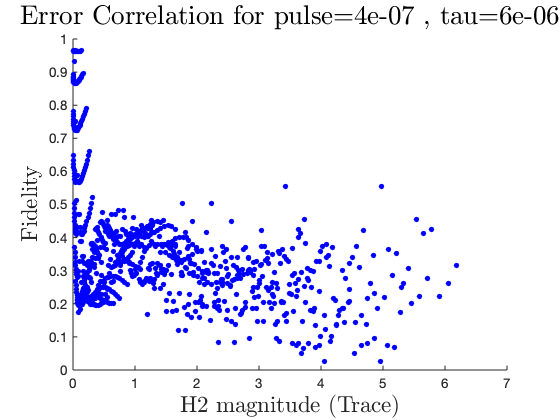

In [35]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .4e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

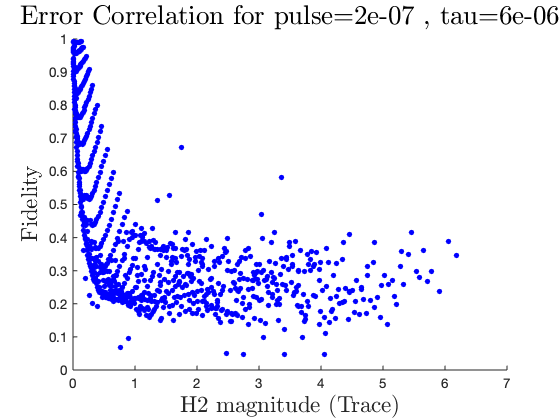

In [36]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h2_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

Because of the more interesting pattern above, the error correlation for h4 and the same pulse-tau values is shown below.

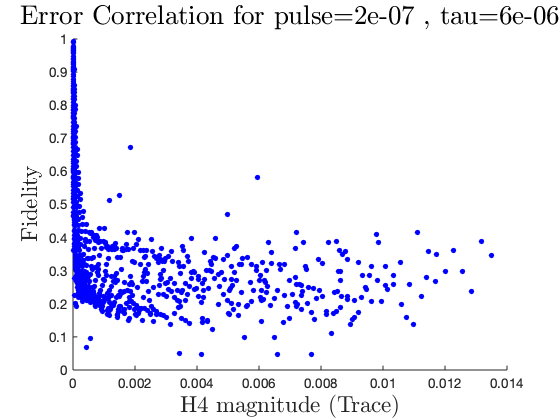

In [37]:
fidFile = 'results/Spinsim-2020/test_results_WHH_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-04-21/h4_WHH_TauDeltaGrid_magnus_results_04-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

I'm not really sure if there's anything noteworthy here.  Clearly high fidelity and low h2,h4 coincide.  But I'm not sure it makes sense to claim that the low fidelity is caused by growth in h2 and h4.

### MREV-8

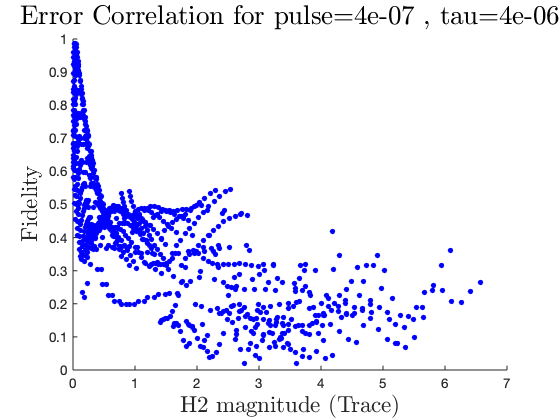

In [38]:
fidFile = 'results/Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-07-21/h2_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

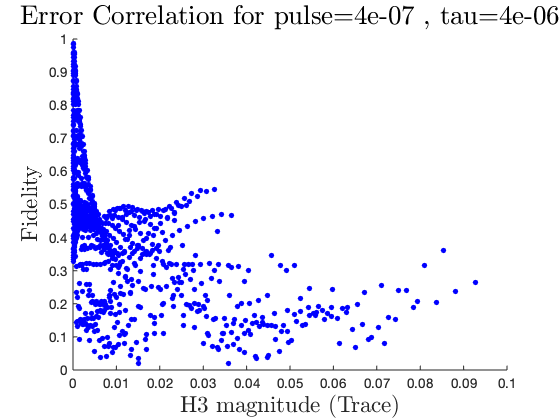

In [39]:
fidFile = 'results/Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-07-21/h3_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H3 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

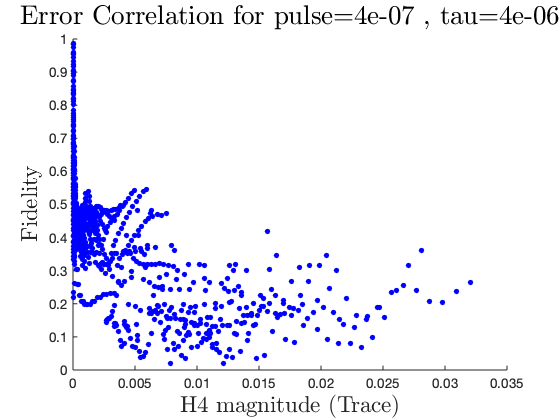

In [40]:
fidFile = 'results/Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-07-21/h4_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .4e-6;
tau = 4e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H4 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

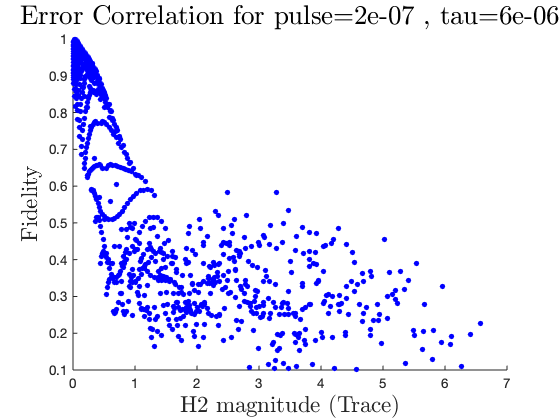

In [41]:
fidFile = 'results/Spinsim-2020/test_results_MREV8_fixedTime_midDelta-THISONE.mat';
magFile = 'results/01-07-21/h2_MREV8_TauDeltaGrid_magnus_results_07-Jan-2021.mat';
pulse = .2e-6;
tau = 6e-6;

r = fidelityMagnusConvert(fidFile,magFile, pulse, tau);
scatter(r.hterms,r.fidelities,17,'blue','filled')
hold on
h = title(strcat('Error Correlation for pulse=',string(pulse),' , tau=',string(tau)));
%h = title(strcat('Error Correlation for tau=',string(tau)));
set(h,'interpreter','latex','fontsize',20);
h = xlabel('H2 magnitude (Trace)');
set(h,'interpreter','latex','fontsize',17);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',17);
%legend('tau = 4us','tau = 8us', 'tau = 2us')
hold off 

## Some Thoughts For Now

In the original Spin Simulation I was running this summer, Fidelity measured the difference between evolving the system under $\bar H^{(0)}$ and a real pulse sequence with some $H(t)$.  Fidelity thus effectively measures how different $H$ is from $\bar H^{(0)}$. There are only two ways I can think of them to differ.  One is that the terms $\bar H^{(n)}$ for $n>0$ are large enough to cause a drop in fidelity.  The other is that the Magnus approximation ignores pulse duration.  Given how in the real experiment pulse length causes the greatest drop in Fidelity, I think it is most likely the latter that is the greatest source of error.

AN IDEA: Since I can numerically calculate at least the first few terms of the magnus expansion fairly easily, I can try evolving under WAHUHA and MREV8 using $\bar H^{(0)} +\bar H^{(1)}+ \bar H^{(2)}$ as my theoretical Hamiltonian.  Since for the most part $\bar H^{(3)}$ and higher order terms are very small compared to the earlier terms (and also very taxing to calculate) this should isolate error due to later order terms and only show fidelity based on other errors (most likely finite-pulse errors).

*There ended up being issues with the above method because when the exact code I had been running in Summer 2020 was run alongside a version that had been modified to be more efficient, different results were obtained. I have not yet found the source of the discrepancy.*

## Analysis: Tau Results

### Review of WHH Tau Results

In [42]:
% reconfigure WHH
tau_results = load('results/01-18-21/TauWHH_Tau_magnus_results_18-Jan-2021.mat');
w_taus = tau_results.testVars;
w_h0s = 10.^tau_results.results_h0(:,1);
w_h2s = 10.^tau_results.results_h2(:,1);
w_h4s = 10.^tau_results.results_h4(:,1);

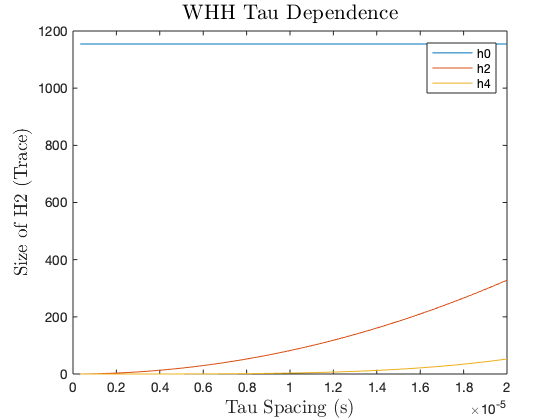

In [43]:
plot(w_taus,w_h0s)
hold on
plot(w_taus,w_h2s)
hold on
plot(w_taus,w_h4s)
h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2 (Trace)');
set(h,'interpreter','latex','fontsize',14);
legend('h0','h2','h4')

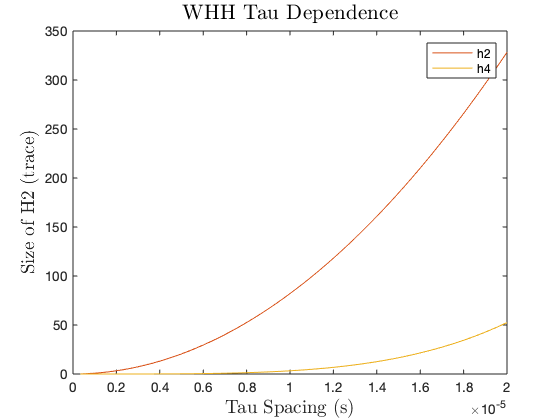

In [44]:
plot(w_taus,w_h2s,'Color',[0.8500, 0.3250, 0.0980])
hold on
plot(w_taus,w_h4s,'Color',[0.9290, 0.6940, 0.1250])
h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H2 (trace)');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h4')

### MREV8 Tau Results
(They should be up top but they're not so here they are)

In [45]:
m_results = load('results/02-07-21/TauMREV8_Tau_magnus_results_07-Feb-2021.mat');
m_taus = m_results.testVars;
m_h0s = 10.^m_results.results_h0;
m_h1s = 10.^m_results.results_h1;
m_h2s = 10.^m_results.results_h2;
m_h3s = 10.^m_results.results_h3;
m_h4s = 10.^m_results.results_h4;

mf_results = load('results/04-03-21/MREV8_fidelity_tau.mat');
mf_taus = mf_results.taus(:,1);
mf_fids = mf_results.results(:,1);

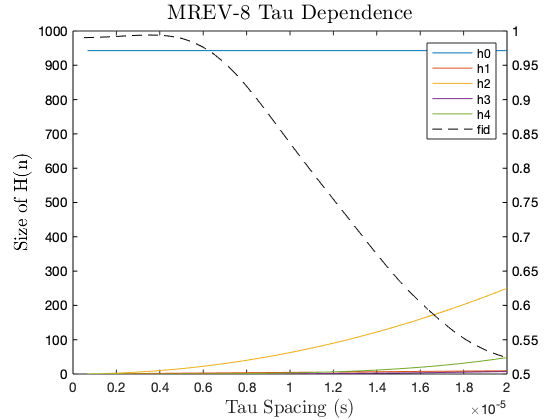

In [46]:
plot(m_taus,m_h0s)
hold on
plot(m_taus,m_h1s,'Color',color1)
plot(m_taus,m_h2s,'Color',color2)
plot(m_taus,m_h3s,'Color',color3)
plot(m_taus,m_h4s,'Color',color4)
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(mf_taus,mf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)



h=title('MREV-8 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
legend('h0','h1','h2','h3','h4','fid')

### CORY-48 Results

On February 7th I finally ran a full tau test for Cory-48.  It took 66 hours to calculate $\bar H^{(0)}$ through $\bar H^{(4)}$ for 30 different values of $\tau$.  Those results are shown below.  For Cory 48 we have $h_0\approx 0\approx h_1$ so only $h_2$ through $h_4$ are shown below.  Fidelity after 20 cycles is superimposed.

In [47]:
results = load('results/02-07-21/TauCORY48_Tau_magnus_results_06-Feb-2021.mat');

taus = results.testVars;
h0s = 10.^results.results_h0;
h1s = 10.^results.results_h1;
h2s = 10.^results.results_h2;
h3s = 10.^results.results_h3;
h4s = 10.^results.results_h4;

cf_results = load('results/04-03-21/CORY_fidelity_tau.mat');
cf_taus = cf_results.taus(:,1);
cf_fids = cf_results.results(:,1);

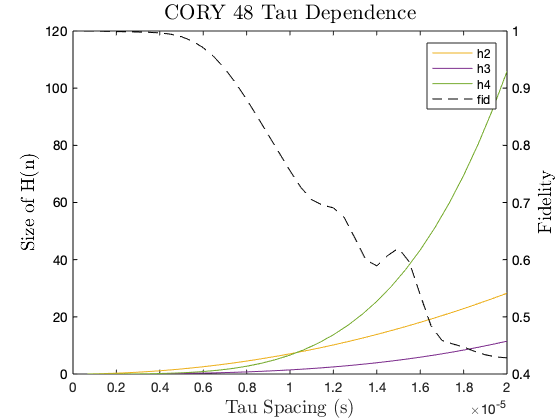

In [48]:
plot(taus,h2s(:,1),'Color',color2)
hold on
plot(taus,h3s(:,1),'Color',color3)
plot(taus,h4s,'Color',color4)
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(cf_taus,cf_fids,'Color',colorf,'LineStyle','--')
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor',colorf)

h=title('CORY 48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h2','h3','h4','fid')

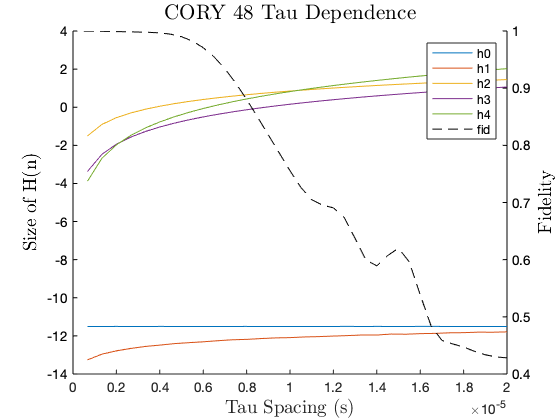

In [49]:
hold on
plot(taus,log10(h0s(:,1)),'Color',color0)
plot(taus,log10(h1s(:,1)),'Color',color1)
plot(taus,log10(h2s(:,1)),'Color',color2)
plot(taus,log10(h3s(:,1)),'Color',color3)
plot(taus,log10(h4s),'Color',color4)
h = ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(cf_taus,cf_fids,'Color',colorf,'LineStyle','--')
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor',colorf)

h=title('CORY 48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

Cory-48 averages out all 0th order and 1st order terms, so only the 2nd-4th order terms are shown above.

Compare again with WHH and MREV:

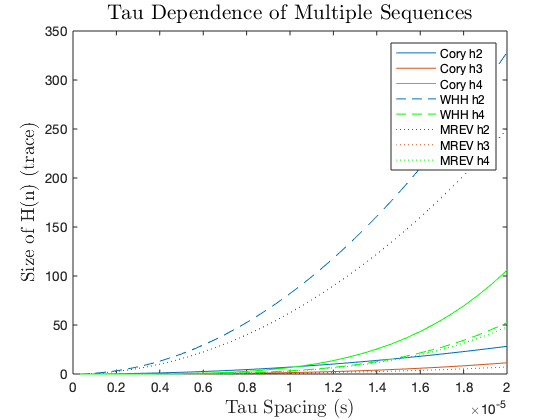

In [50]:
plot(taus,h2s(:,1),'Color',[0, 0.4470, 0.7410])
hold on
plot(taus,h3s(:,1),'Color',[0.8500, 0.3250, 0.0980])
hold on
plot(taus,h4s,'Color','green')
hold on
plot(w_taus,w_h2s,'Color',[0, 0.4470, 0.7410],'LineStyle','--')
hold on
plot(w_taus,w_h4s,'Color','green','LineStyle','--')
hold on
plot(m_taus,m_h2s,'Color',[0, 0.4470, 0.7410],'LineStyle',':')
hold on
plot(m_taus,m_h3s,'Color',[0.8500, 0.3250, 0.0980],'LineStyle',':')
hold on
plot(m_taus,m_h4s,'Color','green','LineStyle',':')
h=title('Tau Dependence of Multiple Sequences');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n) (trace)');
set(h,'interpreter','latex','fontsize',14);
legend('Cory h2','Cory h3','Cory h4', 'WHH h2', 'WHH h4','MREV h2','MREV h3','MREV h4')

We observe that the size of $\bar H^{(n)}$ varies almost exactly as $\tau^n$ and thus as $\tau$ grows the higher order terms become more and more relevant, particularly with longer pulse sequences like Cory 48.

Fitting these curves as $h_n(\tau)=a\tau^n$ yields:

In [51]:
f2=fit(taus,h2s,'poly2');
f3=fit(taus,h3s,'poly3');
f4=fit(taus,h4s,'poly4');

> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)
> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)
> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)


For Cory-48 we obtain fits of:

$h_2(\tau)=\left(7.06\times 10^{10}\right) \tau ^2$

$h_3(\tau)=\left(1.435\times 10^{15}\right)\tau ^3$

$h_4(\tau)=\left(6.617\times 10^{20}\right) \tau ^4$

Do these coefficients mean anything?

We expected the dependence on $\tau ^n$ so what if we take the $n^{\text{th}}$ root of each coefficient?  We then write each curve in the form $h_n(\tau)=(b\tau)^n$ and obtain:

$h_2(\tau)=\left(\tau \cdot 2.66\times 10^{5}\right)^2$

$h_3(\tau)=\left(\tau\cdot 1.13\times 10^{5}\right)^3$

$h_4(\tau)=\left(\tau\cdot 1.60\times 10^{5}\right)^4$

None of these constants are particularly similar or noteworthybeyond their order of magnitude, unfortunately

What about WHH?

In [52]:
fit(w_taus,w_h2s,'poly2');
fit(w_taus,w_h4s,'poly4');

> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)
> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)


For WAHUHA we have:

$h_2^{(w)}(\tau)=\left(8.21\times 10^{11}\right)\tau ^2$

$h_4^{(w)}(\tau)=\left(3.28\times 10^{20}\right)\tau ^4$

Performing the same transformation as before:

$h_2^{(w)}(\tau)=\left(\tau\cdot 9.06\times 10^{5}\right) ^2$

$h_4^{(w)}(\tau)=\left(\tau\cdot 6.90\times 10^{6}\right)^4$

And nothing particularly stands out as informative.

Considering MREV8:

In [53]:
f1=fit(m_taus,10.^m_h1s, 'poly1');
f2=fit(m_taus,10.^m_h2s,'poly2');
f3=fit(m_taus,10.^m_h3s,'poly3');
f4=fit(m_taus,10.^m_h4s,'poly4');

> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)
> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)
> In curvefit.attention/Warning/throw (line 30)
  In fit>iLinearFit (line 680)
  In fit>iFit (line 391)
  In fit (line 116)


For MREV-8 we have the equally uninspiring:

$h_1^{(m)}(\tau)=\left(4.71\times 10^5\right)\tau$

$h_2^{(m)}(\tau)=\left(6.25\times 10^{11}\right)\tau^2=\left(\tau\cdot 7.91\times 10^5\right)^2$

$h_3^{(m)}(\tau)=\left(8.98\times 10^{14}\right)\tau^3=\left(\tau\cdot 9.65\times 10^4\right)^3$

$h_4^{(m)}(\tau)=\left(3.00\times 10^{20}\right)\tau^4=\left(\tau\cdot 1.32\times 10^5\right)^4$

I had hoped to find some pattern in these coefficients, but none emerged.

## Average Hamiltonians with Zero Offset

The terms the Average Hamiltonian for Cory 48 when $\Delta = 0$ have magnitudes as follows:

In [54]:
cory_nodelta = load('results/02-11-21/CORY48_Tau_magnus_results_11-Feb-2021.mat');

cnd_taus = cory_nodelta.testVars;
cnd_h0s = 10.^cory_nodelta.results_h0;
cnd_h1s = 10.^cory_nodelta.results_h1;
cnd_h2s = 10.^cory_nodelta.results_h2;
cnd_h3s = 10.^cory_nodelta.results_h3;
cnd_h4s = 10.^cory_nodelta.results_h4;

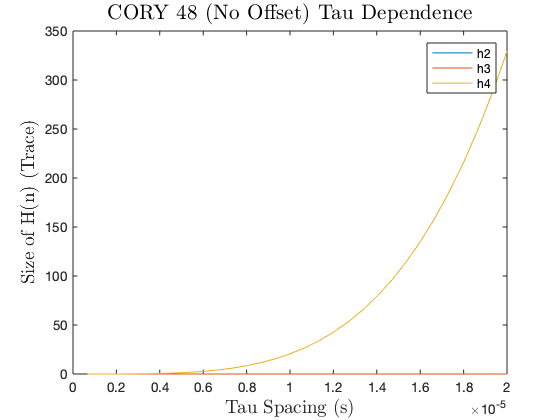

In [55]:
plot(cnd_taus,cnd_h2s(:,1))
hold on
plot(cnd_taus,cnd_h3s(:,1))
hold on
plot(cnd_taus,cnd_h4s)
h=title('CORY 48 (No Offset) Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n) (Trace)');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h3','h4')

Focusing in on h2 and h3:

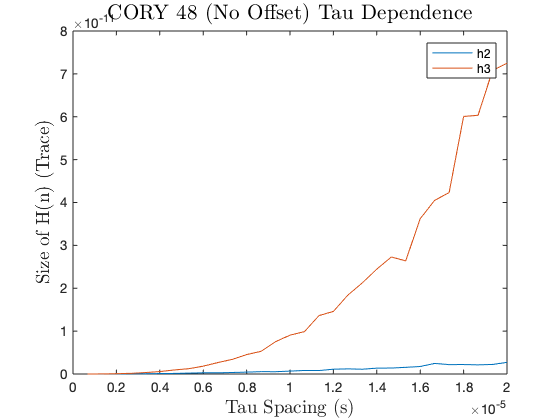

In [56]:
plot(cnd_taus,cnd_h2s(:,1))
hold on
plot(cnd_taus,cnd_h3s(:,1))

h=title('CORY 48 (No Offset) Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n) (Trace)');
set(h,'interpreter','latex','fontsize',14);
legend('h2','h3')

We note that the y-axis scales as $10^{-11}$. Thus we can see that if there is no offset/chemical shift term, the magnitudes of $\bar H^{(2)}$ and $\bar H^{(3)}$ go to zero and the first relevant term is the fourth order term.

Now we can compare the size of the dipole-dipole terms in $\bar H^{(4)}$ with the overall term:

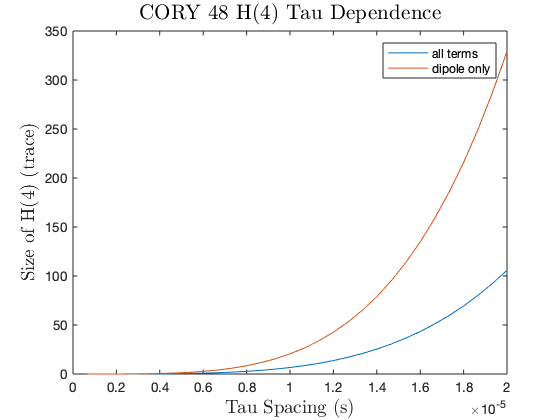

In [57]:
plot(taus,h4s)
hold on
plot(cnd_taus,cnd_h4s)
h=title('CORY 48 H(4) Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(4) (trace)');
set(h,'interpreter','latex','fontsize',14);
legend('all terms','dipole only')

I'm not sure why $\bar H^{(4)}$ would be larger when considering dipole-dipole terms only than when considering all of dipole-dipole, dipole-CS and CS-CS terms.  Maybe this has to do with Second Averaging?

### Deeper Look at WHH-4
##### (or at least an attempt at one)

Re-ran WHH-4 spinsim over 1 test cycle to be on equal footing with the Avg. Hamiltonian calculations.  Ran using a theoretical unitary based on both $\bar H^{(0)}$ and $\bar H^{(0)}+\bar H^{(2)}$ and compared fidelities.  Tried to correlate decrease in fidelity with increase in a higher order term (in this case, $\bar H^{(2)}$ and/or $\bar H^{(4)}$ ) Ran this at the same time as re-running the summer code (before result collection was fixed) to see if baseline results match up

WHH-4 Tau correlation for $\Delta=500\text{ Hz}$ and for $\Delta=0$

In [58]:
wd0=load('results/03-07-21/WHH_Tau_magnus_results_07-Mar-2021.mat');  % delta = 0
wdnz=load('results/03-07-21/nonzerodelta_WHH_Tau_magnus_results_07-Mar-2021.mat');  % delta = 500 Hz
whh_taus=wd0.testVars;

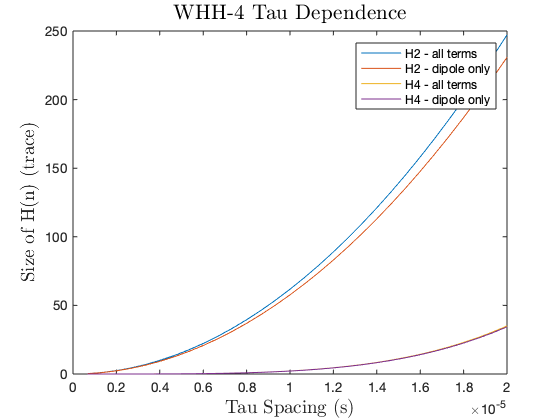

In [59]:
plot(whh_taus,10.^wdnz.results_h2)
hold on
plot(whh_taus,10.^wd0.results_h2)
hold on
plot(whh_taus,10.^wdnz.results_h4)
hold on
plot(whh_taus,10.^wd0.results_h4)
h=title('WHH-4 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Size of H(n) (trace)');
set(h,'interpreter','latex','fontsize',14);
legend('H2 - all terms','H2 - dipole only','H4 - all terms', 'H4 - dipole only')

During summer 2020 I observed that WHH performed best with an offset of around 500 Hz.  However, there is no substantial difference between either of these terms with an increased offset.

A quick stop for calibration: the plots below should look the same if the updated SpinSim code (modified to be more efficient) produces the same results as the code I was running over the summer.

In [60]:
calib_1=load('results/03-08-21/test_results_WHH_CalibrationCheck.mat');
calib_2=load('results/03-08-21/WHH_H0+H1+H2_meshing=30_07-Mar-2021.mat');

In [61]:
r1=calib_1;
meshing=30;
maxTau = 6.5;
maxPulse = 1.4;
maxDelta = 2000;
maxCoupling = 4000;

taus=zeros(meshing,1);
pulses=zeros(meshing,1);
deltas = zeros(meshing,1);
couplings=zeros(meshing,1);

for i=1:meshing
    taus(i)=(maxTau/meshing)*i*10^(-6);
    pulses(i)=(maxPulse/meshing)*i*10^(-6);
    deltas(i)=(-1) * maxDelta + 2*(maxDelta/meshing)*i;
    couplings(i)=(maxCoupling/meshing)*i;
end

isoContours = [0.999 0.9999 0.99999];
V = zeros(meshing, meshing, meshing);
colors = {'green', 'red','blue'};

In [62]:
r2=struct;
r2.resultArray=zeros(meshing,meshing,meshing,meshing);
for i=1:6
    toAdd=(1/6)*squeeze(calib_2.raw_f_results1(i,:,:,:,:));
    r2.resultArray = r2.resultArray + toAdd;
end


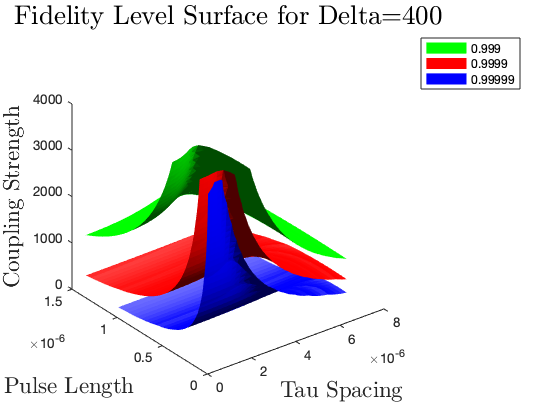

In [63]:
% Using the old script
r=r1;
for i=1:meshing
    deltas(i)=(-1) * maxDelta + 2*(maxDelta/meshing)*i;
end
chosenDeltaIndex=18;
fixed_offset_plot

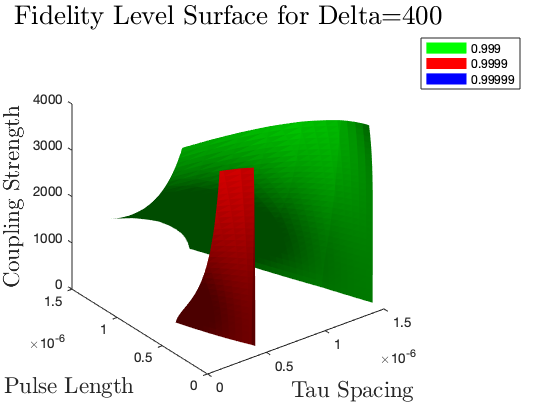

In [64]:
% Using the new script
r=r2;
for i=1:meshing
    deltas(i)=(i/meshing)*maxDelta;
end
chosenDeltaIndex=6;
fixed_offset_plot

These plots should exactly or almost exactly match, but they do not.  This means that either there is an issue with the modified code, or that there was an issue with the code I was running last summer.  I haven't been able to find any error in either yet.

## New Size Metric (Scaled)

# THE RESULTS BELOW FOR SEQUENCES LONGER THAN 8 PULSES ARE CURRENTLY NOT CORRECT AND SHOULD NOT BE USED

The metric for measuring the size of each term in the Magnus expansion was adjusted to the following: $$\text{Size}\big(\bar H^{(n)}\big)=\sqrt{\frac{\text{Tr}\big(\bar H^{(n)}.\bar H^{(n)}\big)}{\text{Tr}\big(H_{sys}.H_{sys}\big)}}$$

i.e, the size is scaled by the original size metric applied to the system Hamiltonian.  The plots above are replicated below with this new metric.

### $\tau$ Dependence

In [3]:
ws_results = load('results/04-08-21/WHH_Tau_magnus_results_08-Apr-2021.mat');
ws_taus = ws_results.testVars;
ws_h0s = ws_results.results_h0;
ws_h1s = ws_results.results_h1;
ws_h2s = ws_results.results_h2;
ws_h3s = ws_results.results_h3;
ws_h4s = ws_results.results_h4;

wsf_results = load('results/04-07-21/WHH_fidelity_tau.mat');
wsf_taus = wsf_results.taus(:,1);
wsf_fids = wsf_results.results(:,1);
wsf_hifids = wsf_results.results_h2(:,1);

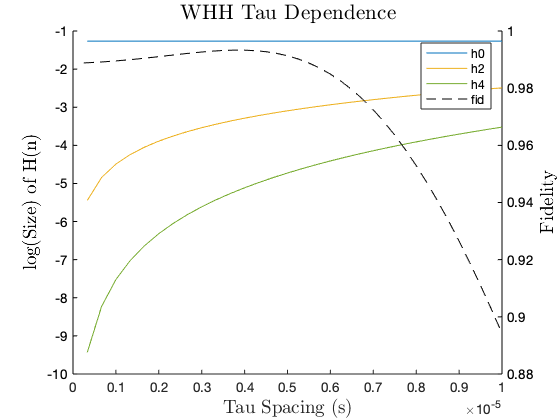

In [4]:
hold on
plot(ws_taus,log10(ws_h0s))
plot(ws_taus,log10(ws_h2s),'Color',color2)
plot(ws_taus,log10(ws_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wsf_taus,wsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h2','h4','fid')

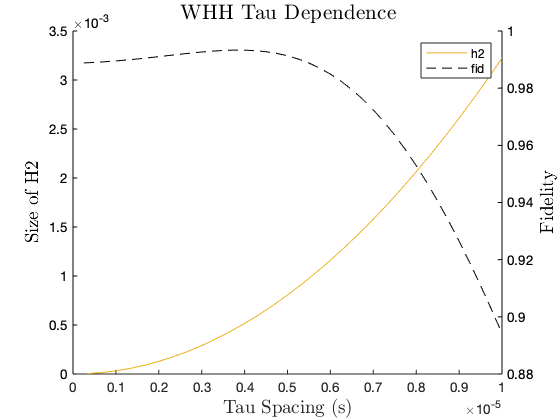

In [5]:
hold on
plot(ws_taus,ws_h2s,'Color',color2)
h = ylabel('Size of H2');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wsf_taus,wsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h2','fid')

In [6]:
ms_results = load('results/04-08-21/MREV8_Tau_magnus_results_08-Apr-2021.mat');
ms_taus = ms_results.testVars;
ms_h0s = ms_results.results_h0;
ms_h1s = ms_results.results_h1;
ms_h2s = ms_results.results_h2;
ms_h3s = ms_results.results_h3;
ms_h4s = ms_results.results_h4;

msf_results = load('results/04-07-21/MREV8_fidelity_tau.mat');
msf_taus = msf_results.taus(:,1);
msf_fids = msf_results.results(:,1);
msf_hifids = msf_results.results_h2(:,1);

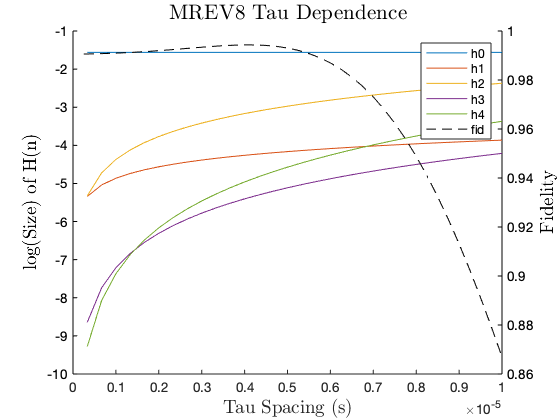

In [7]:
hold on
plot(ms_taus,log10(ms_h0s))
plot(ms_taus,log10(ms_h1s))
plot(ms_taus,log10(ms_h2s))
plot(ms_taus,log10(ms_h3s))
plot(ms_taus,log10(ms_h4s))
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(msf_taus,msf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('MREV8 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

In [4]:
cs_results = load('results/04-10-21/CORY48_Tau_magnus_results_10-Apr-2021.mat');
cs_taus = cs_results.testVars;
cs_h0s = cs_results.results_h0;
cs_h1s = cs_results.results_h1;
cs_h2s = cs_results.results_h2;
cs_h3s = cs_results.results_h3;
cs_h4s = cs_results.results_h4;

csf_results = load('results/04-10-21/CORY48_fidelity_tau.mat');
csf_taus = csf_results.taus(:,1);
csf_fids = csf_results.results(:,1);
csf_hifids = csf_results.results_h2(:,1);

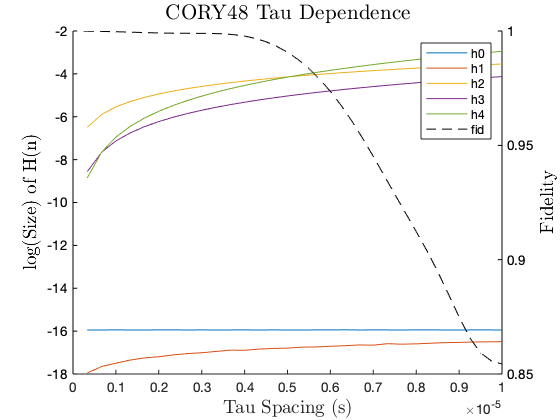

In [5]:
hold on
plot(cs_taus,log10(cs_h0s))
plot(cs_taus,log10(cs_h1s))
plot(cs_taus,log10(cs_h2s))
plot(cs_taus,log10(cs_h3s))
plot(cs_taus,log10(cs_h4s))
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(csf_taus,csf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('CORY48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

In [6]:
% still awaiting results
yxxs_results = load('results/04-10-21/YXX48_Tau_magnus_results_10-Apr-2021.mat');
yxxs_taus = yxxs_results.testVars;
yxxs_h0s = yxxs_results.results_h0;
yxxs_h1s = yxxs_results.results_h1;
yxxs_h2s = yxxs_results.results_h2;
yxxs_h3s = yxxs_results.results_h3;
yxxs_h4s = yxxs_results.results_h4;

yxxsf_results = load('results/04-10-21/YXX48_fidelity_tau.mat');
yxxsf_taus = yxxsf_results.taus(:,1);
yxxsf_fids = yxxsf_results.results(:,1);
yxxsf_hifids = yxxsf_results.results_h2(:,1);

Error using load
Unable to read file 'results/04-10-21/YXX48_Tau_magnus_results_10-Apr-2021.mat'. No such file or directory.


> In legend>process_inputs (line 594)
  In legend>make_legend (line 335)
  In legend (line 279)


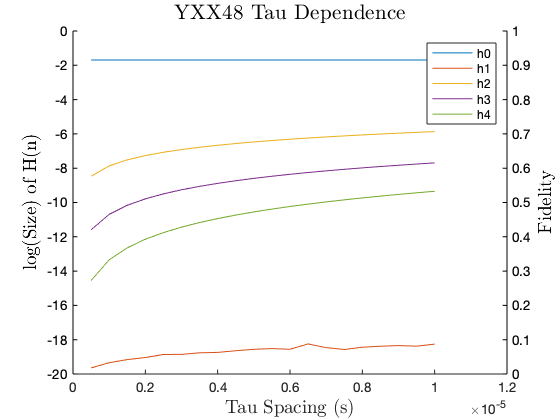

In [15]:
hold on
plot(yxxs_taus,log10(yxxs_h0s))
plot(yxxs_taus,log10(yxxs_h1s))
plot(yxxs_taus,log10(yxxs_h2s))
plot(yxxs_taus,log10(yxxs_h3s))
plot(yxxs_taus,log10(yxxs_h4s))
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(yxxsf_taus,yxxsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('YXX48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

In [8]:
azs_results = load('results/04-10-21/AZ48_Tau_magnus_results_10-Apr-2021.mat');
azs_taus = azs_results.testVars;
azs_h0s = azs_results.results_h0;
azs_h1s = azs_results.results_h1;
azs_h2s = azs_results.results_h2;
azs_h3s = azs_results.results_h3;
azs_h4s = azs_results.results_h4;

azsf_results = load('results/04-10-21/AZ48_fidelity_tau.mat');
azsf_taus = azsf_results.taus(:,1);
azsf_fids = azsf_results.results(:,1);
azsf_hifids = azsf_results.results_h2(:,1);

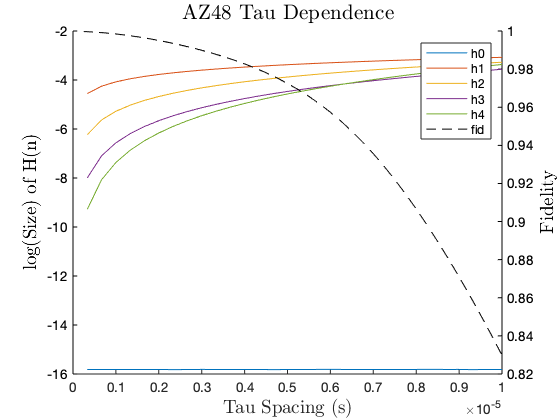

In [10]:
hold on
plot(azs_taus,log10(azs_h0s))
plot(azs_taus,log10(azs_h1s))
plot(azs_taus,log10(azs_h2s))
plot(azs_taus,log10(azs_h3s))
plot(azs_taus,log10(azs_h4s))
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(azsf_taus,azsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('AZ48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

Comparing Cory-48 and YXX-48:

Error using eval
Unrecognized function or variable 'yxxs_taus'.


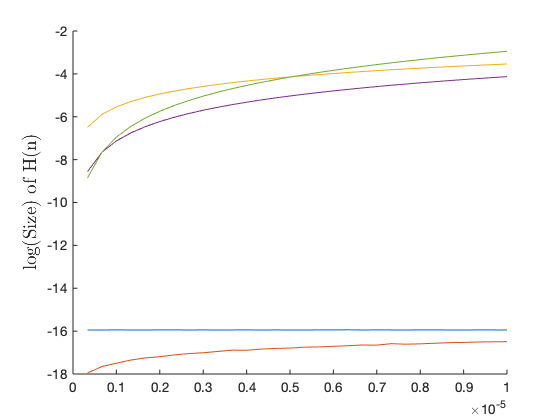

In [11]:
hold on
plot(cs_taus,log10(cs_h0s))
plot(cs_taus,log10(cs_h1s))
plot(cs_taus,log10(cs_h2s))
plot(cs_taus,log10(cs_h3s))
plot(cs_taus,log10(cs_h4s))
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

hold on
plot(yxxs_taus,log10(yxxs_h0s),'Color',color0,'LineStyle','--')
plot(yxxs_taus,log10(yxxs_h1s),'Color',color1,'LineStyle','--')
plot(yxxs_taus,log10(yxxs_h2s),'Color',color2,'LineStyle','--')
plot(yxxs_taus,log10(yxxs_h3s),'Color',color3,'LineStyle','--')
plot(yxxs_taus,log10(yxxs_h4s),'Color',color4,'LineStyle','--')
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);


yyaxis right
%plot(csf_taus,csf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('CORY48 and YXX48 Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s)');
set(h,'interpreter','latex','fontsize',14);

legend('cory h0','cory h1','cory h2','cory h3','cory h4','yxx h0','yxx h1','yxx h2','yxx h3','yxx h4', 'cory fid','yxx fid')

### $\Delta$ Dependence

In [13]:
wds_results = load('results/04-08-21/WHH_Delta_magnus_results_08-Apr-2021.mat');
wds_deltas = wds_results.testVars;
wds_h0s = wds_results.results_h0;
wds_h1s = wds_results.results_h1;
wds_h2s = wds_results.results_h2;
wds_h3s = wds_results.results_h3;
wds_h4s = wds_results.results_h4;

wdsf_results = load('results/04-08-21/WHH_fidelity_Delta.mat');
wdsf_deltas = wdsf_results.deltas(:,1);
wdsf_fids = wdsf_results.results(:,1);


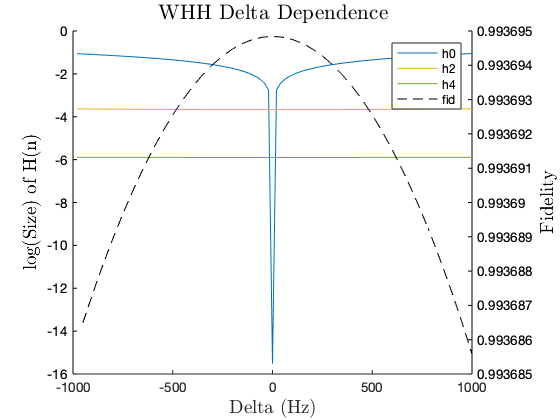

In [14]:
hold on
plot(wds_deltas,log10(wds_h0s))
plot(wds_deltas,log10(wds_h2s),'Color',color2)
plot(wds_deltas,log10(wds_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wdsf_deltas,wdsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h2','h4','fid')

In [15]:
mds_results = load('results/04-08-21/MREV8_Delta_magnus_results_08-Apr-2021.mat');
mds_deltas = mds_results.testVars;
mds_h0s = mds_results.results_h0;
mds_h1s = mds_results.results_h1;
mds_h2s = mds_results.results_h2;
mds_h3s = mds_results.results_h3;
mds_h4s = mds_results.results_h4;

mdsf_results = load('results/04-08-21/MREV8_fidelity_Delta.mat');
mdsf_deltas = mdsf_results.deltas(:,1);
mdsf_fids = mdsf_results.results(:,1);


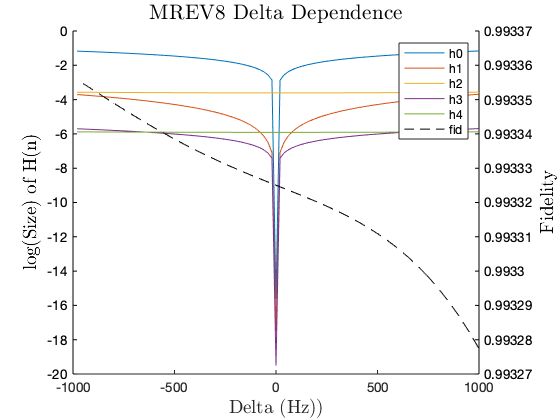

In [16]:
hold on
plot(mds_deltas,log10(mds_h0s))
plot(mds_deltas,log10(mds_h1s),'Color',color1)
plot(mds_deltas,log10(mds_h2s),'Color',color2)
plot(mds_deltas,log10(mds_h3s),'Color',color3)
plot(mds_deltas,log10(mds_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(mdsf_deltas,mdsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('MREV8 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

In [25]:
cds_results = load('results/04-10-21/CORY48_Delta_magnus_results_10-Apr-2021.mat');
cds_deltas = cds_results.testVars;
cds_h0s = cds_results.results_h0;
cds_h1s = cds_results.results_h1;
cds_h2s = cds_results.results_h2;
cds_h3s = cds_results.results_h3;
cds_h4s = cds_results.results_h4;

cdsf_results = load('results/04-10-21/CORY48_fidelity_Delta.mat');
cdsf_deltas = cdsf_results.deltas(:,1);
cdsf_fids = cdsf_results.results(:,1);


Error using load
Unable to read file 'results/04-10-21/CORY48_fidelity_Delta.mat'. No such file or directory.


> In legend>process_inputs (line 594)
  In legend>make_legend (line 335)
  In legend (line 279)


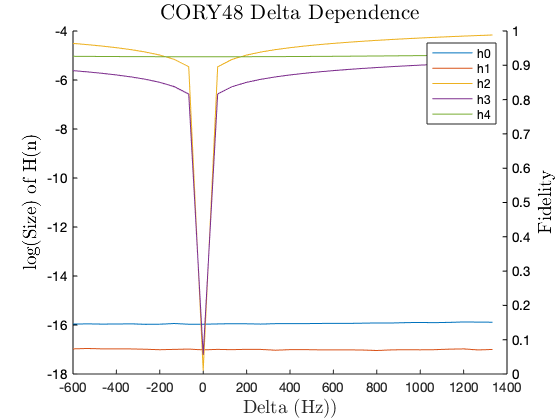

In [26]:
hold on
plot(cds_deltas,log10(cds_h0s))
plot(cds_deltas,log10(cds_h1s),'Color',color1)
plot(cds_deltas,log10(cds_h2s),'Color',color2)
plot(cds_deltas,log10(cds_h3s),'Color',color3)
plot(cds_deltas,log10(cds_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
%plot(cdsf_deltas,cdsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('CORY48 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

In [28]:
% reserved for YXX-48

In [27]:
% reserved for YXX-48

In [29]:
azds_results = load('results/04-10-21/AZ48_Delta_magnus_results_10-Apr-2021.mat');
azds_deltas = azds_results.testVars;
azds_h0s = azds_results.results_h0;
azds_h1s = azds_results.results_h1;
azds_h2s = azds_results.results_h2;
azds_h3s = azds_results.results_h3;
azds_h4s = azds_results.results_h4;

azdsf_results = load('results/04-10-21/AZ48_fidelity_Delta.mat');
azdsf_deltas = azdsf_results.deltas(:,1);
azdsf_fids = azdsf_results.results(:,1);


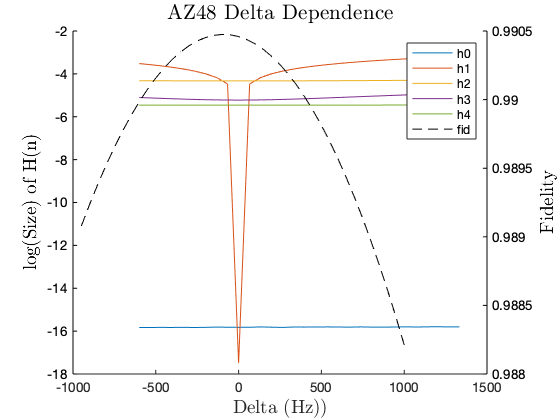

In [31]:
hold on
plot(azds_deltas,log10(azds_h0s))
plot(azds_deltas,log10(azds_h1s),'Color',color1)
plot(azds_deltas,log10(azds_h2s),'Color',color2)
plot(azds_deltas,log10(azds_h3s),'Color',color3)
plot(azds_deltas,log10(azds_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(azdsf_deltas,azdsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('AZ48 Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

### Coupling Dependence

In [17]:
wcs_results = load('results/04-08-21/WHH_Coupling_magnus_results_08-Apr-2021.mat');
wcs_couplings = wcs_results.testVars;
wcs_h0s = wcs_results.results_h0;
wcs_h1s = wcs_results.results_h1;
wcs_h2s = wcs_results.results_h2;
wcs_h3s = wcs_results.results_h3;
wcs_h4s = wcs_results.results_h4;

wcsf_results = load('results/04-08-21/WHH_fidelity_coupling.mat');
wcsf_couplings = wcsf_results.couplings(:,1);
wcsf_fids = wcsf_results.results(:,1);

wcls_results = load('results/04-08-21/WHH_coupling_lo_magnus_results_08-Apr-2021.mat');
wcls_couplings = wcls_results.testVars;
wcls_h0s = wcls_results.results_h0;
wcls_h1s = wcls_results.results_h1;
wcls_h2s = wcls_results.results_h2;
wcls_h3s = wcls_results.results_h3;
wcls_h4s = wcls_results.results_h4;

wclsf_results = load('results/04-08-21/WHH_fidelity_coupling_lo.mat');
wclsf_couplings = wclsf_results.couplings(:,1);
wclsf_fids = wclsf_results.results(:,1);


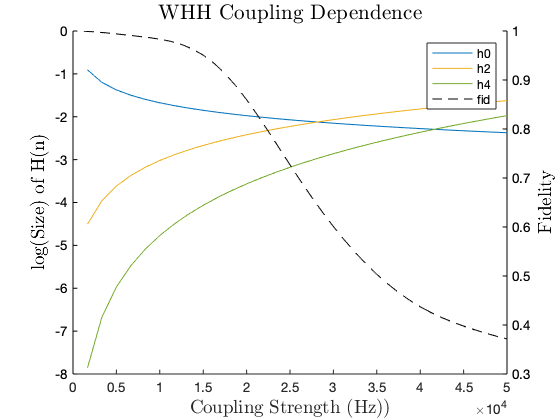

In [18]:
hold on
plot(wcs_couplings,log10(wcs_h0s))
plot(wcs_couplings,log10(wcs_h2s),'Color',color2)
plot(wcs_couplings,log10(wcs_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wcsf_couplings,wcsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h2','h4','fid')

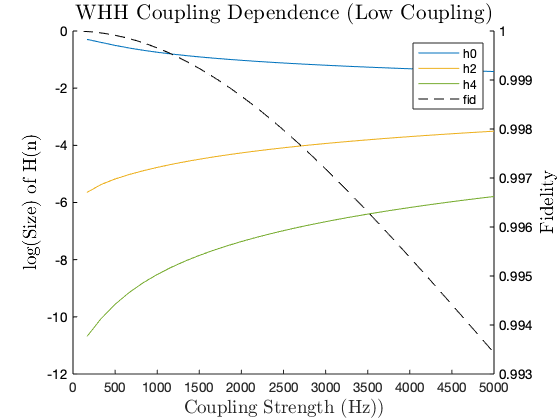

In [19]:
hold on
plot(wcls_couplings,log10(wcls_h0s))
plot(wcls_couplings,log10(wcls_h2s),'Color',color2)
plot(wcls_couplings,log10(wcls_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(wclsf_couplings,wclsf_fids,'Color',colorf,'LineStyle','--')
ylim([0.993 1])
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('WHH Coupling Dependence (Low Coupling)');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h2','h4','fid')

In [20]:
mcs_results = load('results/04-08-21/MREV8_Coupling_magnus_results_08-Apr-2021.mat');
mcs_couplings = mcs_results.testVars;
mcs_h0s = mcs_results.results_h0;
mcs_h1s = mcs_results.results_h1;
mcs_h2s = mcs_results.results_h2;
mcs_h3s = mcs_results.results_h3;
mcs_h4s = mcs_results.results_h4;

mcsf_results = load('results/04-08-21/MREV8_fidelity_coupling.mat');
mcsf_couplings = mcsf_results.couplings(:,1);
mcsf_fids = mcsf_results.results(:,1);

mcls_results = load('results/04-08-21/MREV8_coupling_lo_magnus_results_08-Apr-2021.mat');
mcls_couplings = mcls_results.testVars;
mcls_h0s = mcls_results.results_h0;
mcls_h1s = mcls_results.results_h1;
mcls_h2s = mcls_results.results_h2;
mcls_h3s = mcls_results.results_h3;
mcls_h4s = mcls_results.results_h4;

mclsf_results = load('results/04-08-21/MREV8_fidelity_coupling_lo.mat');
mclsf_couplings = mclsf_results.couplings(:,1);
mclsf_fids = mclsf_results.results(:,1);


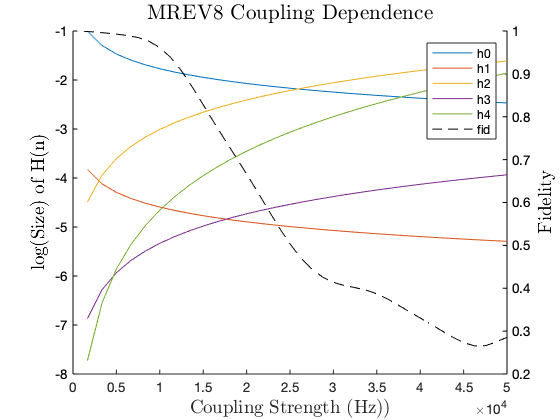

In [21]:
hold on
plot(mcs_couplings,log10(mcs_h0s))
plot(mcs_couplings,log10(mcs_h1s))
plot(mcs_couplings,log10(mcs_h2s),'Color',color2)
plot(mcs_couplings,log10(mcs_h3s))
plot(mcs_couplings,log10(mcs_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(mcsf_couplings,mcsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('MREV8 Coupling Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz))');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

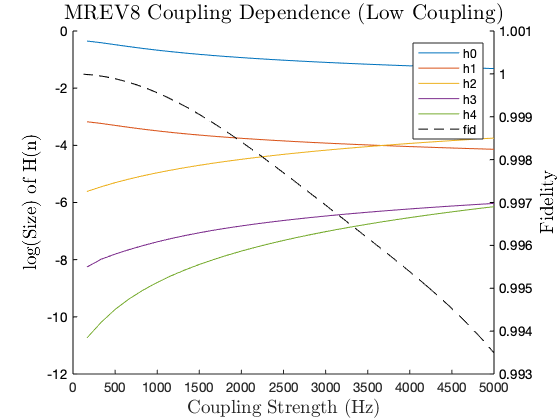

In [22]:
hold on
plot(mcls_couplings,log10(mcls_h0s))
plot(mcls_couplings,log10(mcls_h1s))
plot(mcls_couplings,log10(mcls_h2s),'Color',color2)
plot(mcls_couplings,log10(mcls_h3s))
plot(mcls_couplings,log10(mcls_h4s),'Color',color4)
h = ylabel('log(Size) of H(n)');
set(h,'interpreter','latex','fontsize',14);

yyaxis right
plot(mclsf_couplings,mclsf_fids,'Color',colorf,'LineStyle','--')
set(gca,'ycolor',colorf)
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

h=title('MREV8 Coupling Dependence (Low Coupling)');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Coupling Strength (Hz)');
set(h,'interpreter','latex','fontsize',14);

legend('h0','h1','h2','h3','h4','fid')

## Fidelity Considering Higher Order Terms

We define the fidelity of a pulse sequence to be $$f=\frac{\text{Tr}
    \big(U_{\text{experiment}}U_{\text{target}}^\dagger\big)}{\text{Tr}(\mathbb{1})}$$
The fidelities above are defined using $U_{target}=\mathbb{1}$ for time-suspension sequences (Cory-48, YXX-48, AZ-48) and $U_{target}=e^{-2\pi i \bar H^{(0)}t_{cyc}}$ for the other sequences.

Suppose we redefine $U_{target}$ to be $U_{target}=e^{-2\pi i (\bar H^{(0)}+\bar H^{(1)}+\bar H^{(2)})t_{cyc}}$.  Then if the main cause of fidelity decay is the increase in higher order terms in the magnus expanion, the fidelity metric when using this target unitary should be much higher.

In the plots below, 'fid0' refers to fidelity w.r.t. the former target unitary (calculated using only the zeroth order term) and 'fid2' refers to fidelity w.r.t. the latter target unitary (calculated using up to the second order term, hence the '2').

In [33]:
wsf_results = load('results/04-07-21/WHH_fidelity_tau.mat');
wsf_taus = wsf_results.taus(:,1);
wsf_fids = wsf_results.results(:,1);
wsf_hifids = wsf_results.results_h2(:,1);

wdsf_results = load('results/04-08-21/WHH_fidelity_Delta.mat');
wdsf_deltas = wdsf_results.deltas(:,1);
wdsf_fids = wdsf_results.results(:,1);
wdsf_hifids = wdsf_results.results_h2(:,1);

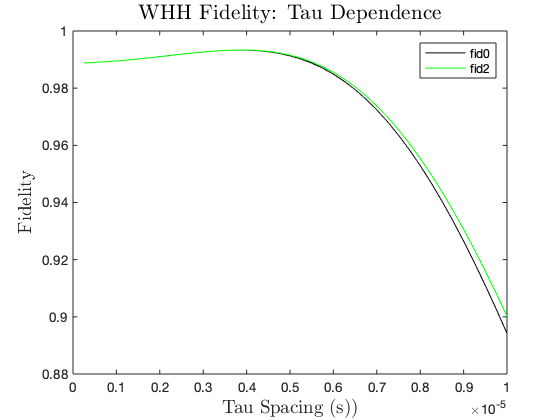

In [62]:
plot(wsf_taus,wsf_fids,'Color',colorf)
hold on
plot(wsf_taus,wsf_hifids,'Color','g')

h=title('WHH Fidelity: Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (s))');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

legend('fid0','fid2')

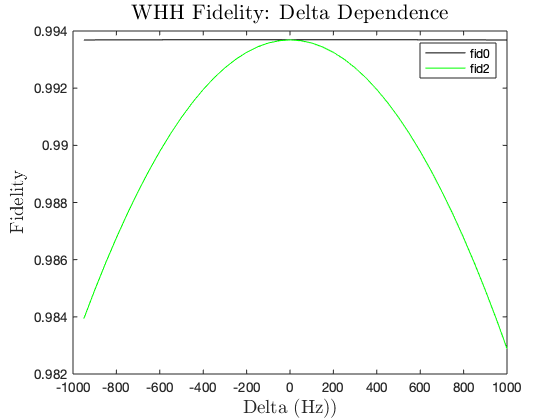

In [65]:
plot(wdsf_deltas,wdsf_fids,'Color',colorf)
hold on
plot(wdsf_deltas,wdsf_hifids,'Color','g')

h=title('WHH Fidelity: Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz))');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

legend('fid0','fid2')

In [40]:
%whh coupling

In [41]:
%whh low coupling

In [55]:
msf_results = load('results/04-07-21/MREV8_fidelity_tau.mat');
msf_taus = msf_results.taus(:,1);
msf_fids = msf_results.results(:,1);
msf_hifids = msf_results.results_h2(:,1);

mdsf_results = load('results/04-08-21/MREV8_fidelity_Delta.mat');
mdsf_deltas = mdsf_results.deltas(:,1);
mdsf_fids = mdsf_results.results(:,1);
mdsf_hifids = mdsf_results.results_h2(:,1);

mcsf_results = load('results/04-10-21/MREV8_fidelity_coupling.mat');
mcsf_couplings = mcsf_results.couplings(:,1);
mcsf_fids = mcsf_results.results(:,1);
mcsf_hifids = mcsf_results.results_h2(:,1);

mclsf_results = load('results/04-10-21/MREV8_fidelity_coupling_lo.mat');
mclsf_couplings = mclsf_results.couplings(:,1);
mclsf_fids = mclsf_results.results(:,1);
mclsf_hifids = mclsf_results.results_h2(:,1);

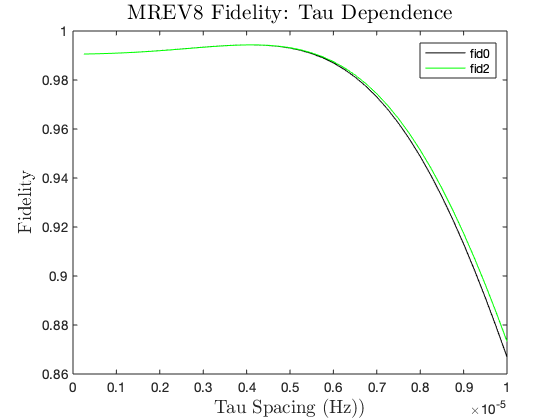

In [59]:
plot(msf_taus,msf_fids,'Color',colorf)
hold on
plot(msf_taus,msf_hifids,'Color','g')

h=title('MREV8 Fidelity: Tau Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Tau Spacing (Hz))');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

legend('fid0','fid2')

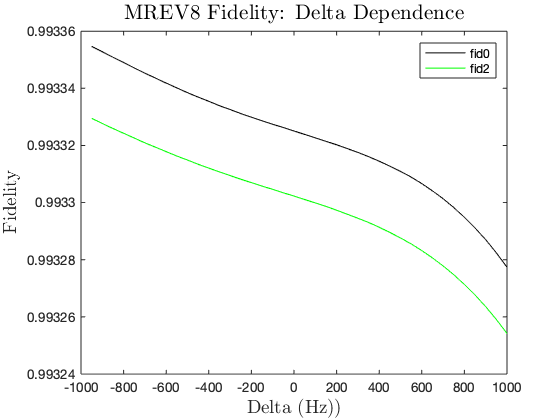

In [61]:
plot(mdsf_deltas,mdsf_fids,'Color',colorf)
hold on
plot(mdsf_deltas,mdsf_hifids,'Color','g')

h=title('MREV8 Fidelity: Delta Dependence');
set(h,'interpreter','latex','fontsize', 16);
h = xlabel('Delta (Hz))');
set(h,'interpreter','latex','fontsize',14);
h = ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);

legend('fid0','fid2')

In [45]:
%mrev8 coupling

In [46]:
%mrev8 low coupling

In [48]:
csf_results = load('results/04-10-21/CORY48_fidelity_tau.mat');
csf_taus = csf_results.taus(:,1);
csf_fids = csf_results.results(:,1);
csf_hifids = csf_results.results_h2(:,1);

%(do not yet exist)
cdsf_results = load('results/04-10-21/CORY48_fidelity_Delta.mat');
cdsf_deltas = cdsf_results.deltas(:,1);
cdsf_fids = cdsf_results.results(:,1);


Error using load
Unable to read file 'results/04-10-21/CORY48_fidelity_Delta.mat'. No such file or directory.
